# RV calculation at Observation Times.

To determine the expected RV shifts of the spectral lines seen my stellar subracted spectra.

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

from PyAstronomy import pyasl   # for doppler shift
import sys
#sys.path.append('/home/jneal/azores/planet/rvs/exonailer/utilities')
try: 
    #import ajplanet
    from ajplanet import pl_rv_array
except:
    pass
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Rodrigo Diaz's true anomaly calculation
def trueanomaly(ma, ecc, niterationmax=10000):
    """
    Compute the true anomaly using the Newton-Raphson method.

    :param array-like ma: mean anomaly.
    :param float ecc: orbital eccentricity.
    :param int niterationmax: maximum number of iterations for N-R method.
    """
    
    if not isinstance(ma, float):
        ea = ma
    else:
        ea = np.array([ma,])

    # Initialise at ea0 = ma
    niteration = 0
    ea0 = ma
    
    while np.linalg.norm(ea - ea0, ord=1) > 1e-5 or niteration==0:
        ea0 = ea
 
        ff = ea - ecc*np.sin(ea) - ma   # Function
        dff = 1 - ecc*np.cos(ea)        # Derivative

        # Use Newton method
        ea = ea0 - ff / dff

        # Increase iteration number; if above limit, break with exception.
        niteration += 1
        if niteration >= niterationmax:
            raise RuntimeError('Eccentric anomaly computation'
                               'not converged.')
        
    # Compute true anomaly from eccentric anomaly
    return 2. * np.arctan2(np.sqrt(1. + ecc) * np.sin(ea/2.),
                           np.sqrt(1. - ecc) * np.cos(ea/2.))

# Mean Anomaly calculation
def meananomaly(t, T0, P):
    """ Calculate mean Anomaly using period, tau and a time value"""
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    return 2 * np.pi * (t - T0) / P

# Basic RV calculation
def radialvelocity(gamma, K, ta, omega, ecc):
    # Calculate radial velocity of star
    return gamma + K *(np.cos(ta + omega) + ecc * np.cos(omega))

# RV calculation done in python (for when ajplanet is not available)
def rv_curve_py(t, gamma, K, omega, ecc, T, P):
    ma = meananomaly(t, T, P)
    ta = trueanomaly(ma, ecc)
    rv = radialvelocity(gamma, K, ta, omega, ecc)
    return rv
        

In [3]:
#Silly epoch of T0 in a paper of 1997.04 +- 0.02 . need to turn into julian days
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#print(0.04 * 365)
#print(.6*24)
#print(.4*60)
# Julian date for CE  1997 January 14 14:24:00.0 UT is JD 2450463.100000

# Orbtial Parameters and epochs.

In [4]:

#Target parameters:  Obtained from sahlmann et al. 

#HD4747_params   = [9.904, 703.3, -94.2, 0.723, 62059.1, 11593.2] # Best fit solution from sahlmann not complete period coverage
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#                 [mean_val, K1, omega,   e,     Tau,       Period, starmass (Msun), msini(Mjup), i] 
d = 365.25  # Days in a year
HD4747_params   = [-0.219,  755.3,  -69.1, 0.740,  50463.10,  37.88*d, 0.81, 46.1]  # turn 37.88 years into days
HD162020_params = [-27.328,  1813,  28.40, 0.277, 51990.677, 8.428198, 0.74, 14.4]  # here mean val in km/s K in m/s https://arxiv.org/pdf/astro-ph/0202458v2.pdf
HD167665_params = [8.003,   609.5, -134.3, 0.340,   56987.6,   4451.8, 1.14, 50.6]  # sahlman
HD211847_params = [6.689,   291.4,  159.2, 0.685,   62030.1,   7929.4, 0.94, 19.2]  # Best fit solution from sahlmann not complete period coverage
HD30501_params =  [23.710, 1703.1,   70.4, 0.741,   53851.5,   2073.6, 0.81, 90]  # sahlman


# 2 companions
# One of these used 3 body equations - need to compare relative strengths
HD168443b_params = [-0.046533, 475.133, 172.923, 0.52883, 15626.199, 58.1125, 0.995, 7.659] #  % msini = 7.659Mjp, a=0.2931AU, dv/dt (ms−1 yr−1) −0.00868
HD168443c_params = [-0.046533, 297.70, 64.87, 0.2113, 15521.3, 1749.83, 0.995, 17.193] 

HD202206b_params = [14.721, 564.75, 161.18, 0.435, 52250.00, 255.87, 1.04, 17.4] #\citet{Correia2005_hd202206bc}\\  % \lambda = 266.228 deg (mean longitude)
HD202206c_params = [14.721, 42.01, 78.9, 0.267, 52250.00, 1383.4, 1.04, 2.44] # \citet{Correia2005_hd202206bc}\\ % \lambda = 30.586 deg (mean longitude)

HD30501_mass = [0.81, 90]  # acutal
HD168443_massb = [0.995, 7.659]
HD168443_massc = [0.995, 17.193] # minimum i 
HD4747_mass = [0.81, 46.1]
HD167665_mass = [1.14, 50.6]  # minimum
HD211847_mass = [0.94, 19.2]
HD162020_mass = [0.74, 14.4]  # minimum
HD202206_massb = [1.04, 17.4]  # minimum
HD202206_massc = [1.04, 2.44]
#Median times 
# extremeties are +- 14 minutes
HD30501_times =  [2456024.505902, 2456140.88716, 2456141.86633, 2456145.904258]  # from data - need to double check with calculated data centers
HD162020_times = [2456112.76624, 2456112.79015]
HD202206_times = [ 2456120.78801, 2456121.73727, 2456119.85411]   
HD211847_times = [2456114.8035, 2456121.78793]  
HD4747_times =   [2456114.81674]
HD167665_times = [2456136.70895, 2456136.73434, 2456144.62087] 
HD168443_times = [2456144.68718, 2456144.70753]
params_dict = {"HD30501":HD30501_params, "HD211847":HD211847_params, \
               "HD4747":HD4747_params, "HD167665":HD167665_params, \
               "HD162020":HD162020_params, \
               "HD202206b":HD202206b_params,"HD202206c":HD202206c_params, \
               "HD168443b":HD168443b_params,"HD168443c":HD168443c_params}
               # "HD202206":HD202206_params,
    
times_dict = {"HD30501":HD30501_times, "HD162020":HD162020_times, \
              "HD202206":HD202206_times, "HD211847":HD211847_times, \
              "HD4747":HD4747_times, "HD167665":HD167665_times, \
             "HD168443":HD168443_times}


# Keplerian Orbital Parameters:

In [17]:
def RV_from_params(t, params, use_offset=True):
    """ Get RV values with parameter list.
    
    input:
        t -- The time/s at which to calculate the RV value
        params -- a list of values [mean_val, K1, omega, e, Tau, Period]
    
    omega should be given in degrees. This function converts it to radians.
    
    Outputs:
        RVs -- The radial velocity values evaluated at the given times.
    
    """
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    #Solar Mass conversion to MJup
    Msun_Mjup = 1047.56 # Mjup
    
    #RV for star
    star_params = params[:]
    planet_params = params[:]
    # Note: test that is np.deg2rad is faster than *np.pi /180
    star_params[2] = np.deg2rad(star_params[2])
    planet_params[2] = np.deg2rad(planet_params[2])
        
    if not use_offset:
        star_params[0] = 0
        planet_params[0] = 0
    else:
        star_params[0] = star_params[0] * 1000 # Turn into m/s
        planet_params[0] = planet_params[0] * 1000 # Turn into m/s
   
    # Scale K for planet
    K1 = planet_params[1]
    mass_ratio = Msun_Mjup*planet_params[6] / planet_params[7]
    #print("star/planet Mass Ratio", mass_ratio)
    K2 = -mass_ratio * K1
    planet_params[1] = K2
    
    #planet_params[2] += np.pi # omeaga phase do I need to add pi### NO!
    
    try: # Try rv_curve first
        #import ajplanet
        star_rvs = pl_rv_array(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = pl_rv_array(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used ajplanet")
    except:
        star_rvs = rv_curve_py(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = rv_curve_py(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used python")
        
    return star_rvs, planet_rvs


def plot_RV_phase_curve(params, name=False, t_vals=False, use_offset=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    phase = np.linspace(-0.1,1.1, 200)
    t = params[4] + phase * params[5]
    
    rv_values, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(phase, rv_values, label="Star")
    plt.plot(phase, planet_rvs/100, label="Planet/100")
    if name:
        plt.title("RV Phase curve for {}".format(name))
    else:
        plt.title("RV Phase curve")
    if t_vals:
        for t_num, t_val in enumerate(t_vals):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, "+",label = "Star Obs #{0}".format(t_num), markersize=16, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, "h",label = "Planet Obs #{0}".format(t_num), markersize=16, markeredgewidth=3)
            plt.legend(loc=0)
    plt.xlabel("Phase")
    plt.ylabel("RV amplitude (m/s)")
    plt.show()
    

def plot_RV_curve_setion(times, params, name=False, use_offset=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    time_diff = np.max(times) - np.min(times)
    
    t = np.linspace(np.min(times),np.max(times))
    #phase = np.linspace(-0.1,1.1, 200)
    #t = params[4] + phase * params[5]
    
    rv_values, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(phase, rv_values, label="Star")
    plt.plot(phase, planet_rvs/100, label="Planet/100")
    if name:
        plt.title("RV Phase curve for {}".format(name))
    else:
        plt.title("RV Phase curve")
    if t_vals:
        for t_num, t_val in enumerate(t_vals):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, "+",label = "Star Obs #{0}".format(t_num), markersize=16, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, "h",label = "Planet Obs #{0}".format(t_num), markersize=16, markeredgewidth=3)
            plt.legend(loc=0)
    plt.xlabel("Phase")
    plt.ylabel("RV amplitude (m/s)")
    plt.show()    

    
def test_rv_curves(t, params):
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    else:
        pass
    params = params[:]
    params[2] = np.deg2rad(params[2])
    params[0] = 0

    aj_rv = pl_rv_array(t, *params) # *unpacks parameters from list
    
    py_rv = rv_curve_py(t, *params)
    
    print("Ajplanet RVs = {}".format(aj_rv))
    print("Python RVs   = {}".format(py_rv))
    return None


def Obs_RV_error(t, params, name=False ):
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    t_start = t - obs_time_sigma
    t_end =  t + obs_time_sigma
    
    star_rv_start, planet_rv_start = RV_from_params(t_start, params, use_offset=False)
    star_rv_end, planet_rv_end = RV_from_params(t_end, params, use_offset=False)
    
    star_diff = star_rv_end - star_rv_start 
    planet_diff = planet_rv_end - planet_rv_start
    #if name:
        #print("RV change over observation for {} m/s".format(RV_difference))
    return star_diff, planet_diff


def RV_calculations(times, params, use_offset=False):
    Msun_Mjup = 1047.56 # Mjup
    
    for target in times:
        print("\nTarget {}".format(target))
        time = times[target]
        
        if target in ["HD202206", "HD168443"]:
            targetb = target + "b" 
            targetc = target + "c"
            paramb = params[targetb]
            paramc = params[targetc]
            
            star_rv_values, planet_rv_values = RV_from_params(time, paramb, use_offset=use_offset)
            star_rv_values_c, planet_rv_values_c = RV_from_params(time, paramc, use_offset=use_offset)
            star_rv_diff_b, planet_rv_diff_b = Obs_RV_error(time, paramb, name=targetb)
            star_rv_diff_c, planet_rv_diff_c = Obs_RV_error(time, paramc, name=targetc)
            print("Radial velocity values of the host star.")
            print("Gamma subtracted RV values for b = {0} m/s".format(star_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(star_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(star_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(star_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(star_rv_values + star_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(star_rv_values + star_rv_values_c)))
            
            print("\nRadial velocity values of the planet.")
            print("Maximum mass ratio value for b   = {0} ".format(Msun_Mjup*paramb[6]/paramb[7]))
            print("Maximum mass ratio value for c   = {0} ".format(Msun_Mjup*paramc[6]/paramc[7]))
            print("Gamma subtracted RV values for b = {0} m/s".format(planet_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(planet_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(planet_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(planet_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(planet_rv_values + planet_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(planet_rv_values + planet_rv_values_c)))
            
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff of b            = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff of b          = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift of b - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift of b - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift of b - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift of b - planet       = {} nm".format(planet_high_doppler))
            
            plot_RV_phase_curve(paramb, name=targetb, t_vals=time, use_offset=False)
            plot_RV_phase_curve(paramc, name=targetc, t_vals=time, use_offset=False)
            
            plot_RV_curve_setion(times, paramsb, name=targetb, use_offset=False)
            plot_RV_curve_setion(times, paramsc, name=targetc, use_offset=False):
      
        else:
            param = params[target]   
                                
            star_rv_values, planet_rv_values = RV_from_params(time, param, use_offset=use_offset)
            star_rv_diff, planet_rv_diff = Obs_RV_error(time, param, name=target)
            print("Radial velocity values of the host star only currently.")
            
            print("Gamma subtracted rv values = {0} m/s".format(star_rv_values))
            print("RV change over exptime     = {0} m/s".format(star_rv_diff))
            
            print("Radial velocity values of the Planet.")
            print("Maximum mass ratio value   = {0} ".format(Msun_Mjup*param[6]/param[7]))
            print("Gamma subtracted rv values = {0} m/s".format(planet_rv_values))
            print("RV change over exptime     = {0} m/s".format(planet_rv_diff))
            # Differences in RV between successive observations
            
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff - star     = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff - planet = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift - planet       = {} nm".format(planet_high_doppler))
            
            
            print("\n\nTesting Values\n")
            print("planet/Star rv_values ratio  ", planet_rv_values/star_rv_values)
            print("planet/Star rv_values ratio  ", planet_rv_diff/star_rv_diff)
            print("planet/Star successive diff ratio ", planet_successive_diff/star_successive_diff)
            print("planet/Star low doppler shift ratio  ", planet_low_doppler/star_low_doppler)
            print("planet/Star high doppler shift ratio ", planet_high_doppler/star_high_doppler)
            
            plot_RV_phase_curve(param, name=target, t_vals=time, use_offset=False)
            plot_RV_curve_setion(time, params, name=target, use_offset=False):
   
    return None

def band_doppler_shifts(RVs):
    """ Calculate wavelenght shift at start and end of observation wavelenght range
    
    To find expected waveleght shifts to look for.
    
    """
    lower_org_wl = 2121.056  #nm
    upper_org_wl = 2160.205  #nm
    #middle_wl = (lower_wl + upper_wl)/2.0
    #wavelengths = np.array([lower_wl, middle_wl,upper_wl])
    wavelengths = np.array([lower_org_wl, upper_org_wl]) * 10
    upper_wls = np.empty_like(RVs)
    lower_wls = np.empty_like(RVs)
    #print(wavelengths)
    for i, rv in enumerate(RVs):
        rv /= 1000  # turn into km/s
        __ , new_wls = pyasl.dopplerShift(wavelengths, np.ones_like(wavelengths), rv, edgeHandling="firstlast")
        #print(i, new_wls)
        #result_wls.append(new_wls - wavelengths)
        lower_wls[i] = new_wls[0] / 10.
        upper_wls[i] = new_wls[1] / 10.
    lower_shifts = lower_wls - lower_org_wl
    upper_shifts = upper_wls - upper_org_wl
    return lower_shifts, upper_shifts




SyntaxError: invalid syntax (<ipython-input-17-5633748edcbd>, line 209)

### Run analysis for all targets:


Target HD162020
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-1258.28312842 -1251.5254267 ] m/s
RV change over exptime     = [ 5.42134529  5.56970799] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 53.83294444444444 
Gamma subtracted rv values = [ 67737.08574759  67373.29876654] m/s
RV change over exptime     = [-291.84698006 -299.83378057] m/s
Successive Star RV Diff - star     = [ 6.75770172] m/s
Successive planet RV Diff - planet = [-363.78698106] m/s
Band Lower wl shift - star         = [  4.78112888e-05] nm
Band Upper wl shift - star         = [  4.86937570e-05] nm
Band Lower wl shift - planet       = [ 0.00257382] nm
Band Upper wl shift - planet       = [ 0.00262133] nm


Testing Values

planet/Star rv_values ratio   [-53.83294444 -53.83294444]
planet/Star rv_values ratio   [-53.83294444 -53.83294444]
planet/Star successive diff ratio  [-53.83294444]
planet/Star low doppler shift ratio   [ 53.83294436]
planet/Star 

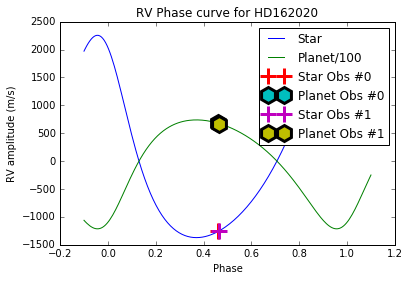


Target HD168443
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ 211.40576895  211.49986415] m/s
RV change over exptime for b     = [ 0.09006337  0.0897528 ] m/s
Gamma subtracted RV values for c = [ 256.45003189  256.46333491] m/s
RV change over exptime for c     = [ 0.01271141  0.01271071] m/s
Combined RV value for triplet    = [ 467.85580083  467.96319906] m/s
Combined RV Diff between Obs     = [ 0.10739823] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 136.09116072594333 
Maximum mass ratio value for c   = 60.62480079101959 
Gamma subtracted RV values for b = [-28770.45648003 -28783.26200495] m/s
RV change over exptime for b     = [-12.25682843 -12.21456221] m/s
Gamma subtracted RV values for c = [-15547.23209591 -15548.03858938] m/s
RV change over exptime for c     = [-0.77062642 -0.77058411] m/s
Combined RV value for triplet    = [-44317.68857594 -44331.30059433] m/s
Combined RV Diff between Obs     = [-13.61201839] m/s

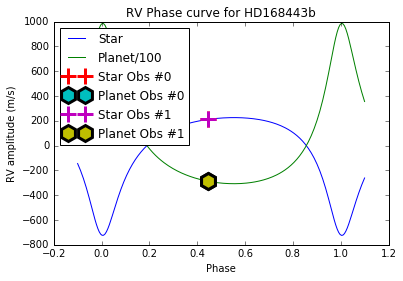

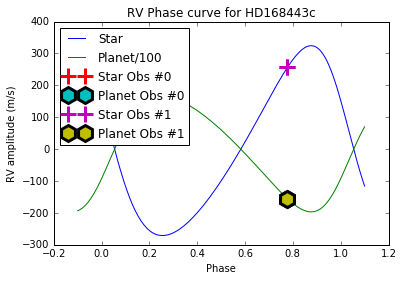


Target HD202206
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ -84.45733491 -103.17581379  -66.71647668] m/s
RV change over exptime for b     = [-0.37629449 -0.39060291 -0.36251126] m/s
Gamma subtracted RV values for c = [ 19.01906301  19.13201534  18.90792277] m/s
RV change over exptime for c     = [ 0.00231386  0.00231352  0.00231417] m/s
Combined RV value for triplet    = [-65.43827191 -84.04379845 -47.80855392] m/s
Combined RV Diff between Obs     = [-18.60552654  36.23524453] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 62.6127816091954 
Maximum mass ratio value for c   = 446.5009836065573 
Gamma subtracted RV values for b = [ 5288.10866611  6460.12469636  4177.30418439] m/s
RV change over exptime for b     = [ 23.56084443  24.45673491  22.69783819] m/s
Gamma subtracted RV values for c = [-8492.03033924 -8542.46366947 -8442.40611348] m/s
RV change over exptime for c     = [-1.03313995 -1.03299068 -1.03328046] m/s
Com

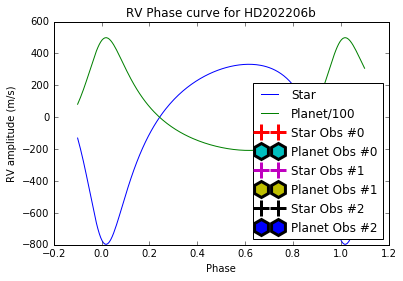

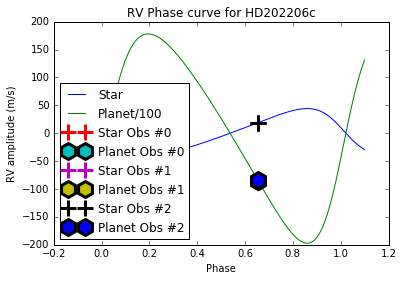


Target HD211847
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-4.29917535 -6.34781552] m/s
RV change over exptime     = [-0.0056411  -0.00576619] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 51.286791666666666 
Gamma subtracted rv values = [ 220.49091034  325.55909217] m/s
RV change over exptime     = [ 0.28931369  0.29572925] m/s
Successive Star RV Diff - star     = [-2.04864017] m/s
Successive planet RV Diff - planet = [ 105.06818183] m/s
Band Lower wl shift - star         = [  1.44942956e-05] nm
Band Upper wl shift - star         = [  1.47618211e-05] nm
Band Lower wl shift - planet       = [ 0.00074337] nm
Band Upper wl shift - planet       = [ 0.00075709] nm


Testing Values

planet/Star rv_values ratio   [-51.28679167 -51.28679167]
planet/Star rv_values ratio   [-51.28679167 -51.28679167]
planet/Star successive diff ratio  [-51.28679167]
planet/Star low doppler shift ratio   [ 51.28679221]
planet/Star high doppler 

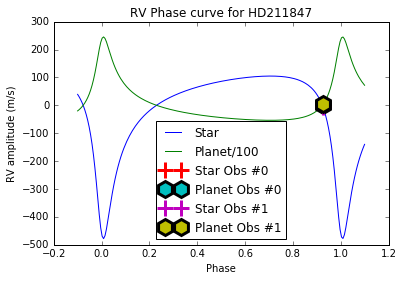


Target HD167665
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-737.64314434 -737.65153927 -740.16865421] m/s
RV change over exptime     = [-0.0064298  -0.00642839 -0.005981  ] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 23.601154150197623 
Gamma subtracted rv values = [ 17409.22955732  17409.42768734  17468.83450509] m/s
RV change over exptime     = [ 0.15175077  0.15171737  0.14115847] m/s
Successive Star RV Diff - star     = [-0.00839493 -2.51711494] m/s
Successive planet RV Diff - planet = [  0.19813002  59.40681775] m/s
Band Lower wl shift - star         = [  5.93950062e-08   1.78087930e-05] nm
Band Upper wl shift - star         = [  6.04914021e-08   1.81374953e-05] nm
Band Lower wl shift - planet       = [  1.40178599e-06   4.20308063e-04] nm
Band Upper wl shift - planet       = [  1.42765930e-06   4.28065821e-04] nm


Testing Values

planet/Star rv_values ratio   [-23.60115415 -23.60115415 -23.60115415]
planet/St

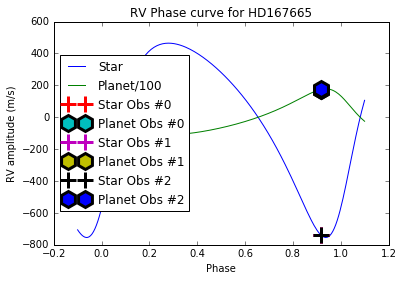


Target HD4747
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-482.37561322] m/s
RV change over exptime     = [-0.00203258] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 18.406151843817785 
Gamma subtracted rv values = [ 8878.67878266] m/s
RV change over exptime     = [ 0.037412] m/s
Successive Star RV Diff - star     = [] m/s
Successive planet RV Diff - planet = [] m/s
Band Lower wl shift - star         = [] nm
Band Upper wl shift - star         = [] nm
Band Lower wl shift - planet       = [] nm
Band Upper wl shift - planet       = [] nm


Testing Values

planet/Star rv_values ratio   [-18.40615184]
planet/Star rv_values ratio   [-18.40615184]
planet/Star successive diff ratio  []
planet/Star low doppler shift ratio   []
planet/Star high doppler shift ratio  []


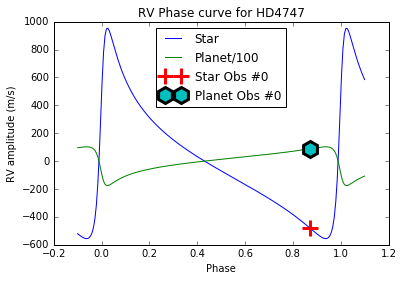


Target HD30501
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-246.88768364 -122.27137959 -121.21000561 -116.82986697] m/s
RV change over exptime     = [ 0.02066453  0.02107387  0.02107985  0.02110496] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 9.42804 
Gamma subtracted rv values = [ 2327.66695686  1152.7794576   1142.77278133  1101.47665896] m/s
RV change over exptime     = [-0.19482603 -0.19868532 -0.19874167 -0.19897842] m/s
Successive Star RV Diff - star     = [ 124.61630405    1.06137397    4.38013865] m/s
Successive planet RV Diff - planet = [-1174.88749926   -10.00667627   -41.29612237] m/s
Band Lower wl shift - star         = [  8.81670477e-04   7.50930712e-06   3.09898369e-05] nm
Band Upper wl shift - star         = [  8.97943747e-04   7.64790866e-06   3.15618263e-05] nm
Band Lower wl shift - planet       = [  8.31242452e-03   7.07980480e-05   2.92173421e-04] nm
Band Upper wl shift - planet       = [  8.465849

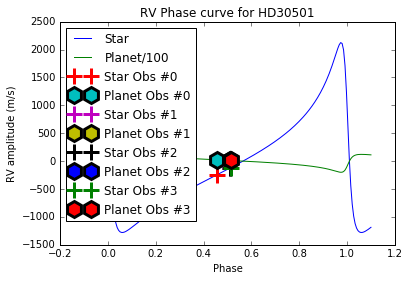

In [18]:
RV_calculations(times_dict, params_dict)

# Also want to add a plot showing a zoom in around the observations only to separate out the markers.

Need to determine how to calculate the expected RV of the planet (not the star) to be able to get proper values out of this. If the planet RV is > 100m/s it would be good for visible detections i think.

I think the RV of planet will be related to mass ratio of Mplanet/Mstar but not sure exactly how...

In [ ]:
## Calcualte K of planet

def RV_planet(time, star_params, masses, only_minimum=False, use_offset=True):
    """ Calcualte RV value for a planet instead of star
    
    Need to change the K value"""
    star_mass = masses[0]
    planet_mass = masses[1]
    
    planet_params = star_params[:]
    
    planet_params[1] = -(star_mass/planet_mass) * planet_params[1] 
    planet_params[2] = planet_params[2] + 180    # phase offset
    
    planet_rv = RV_from_params(time, planet_params, use_offset=use_offset)
    
    return planet_rv


In [ ]:
target = "HD30501"       

print("Mass ratio ", HD30501_mass[0]/HD30501_mass[1])
star_rv = RV_from_params(HD30501_times, HD30501_params, use_offset=False)

planet_rv = RV_planet(HD30501_times, HD30501_params, HD30501_mass, use_offset=False)

print("star_rv   ", star_rv)
print("planet_rv ", planet_rv)




In [ ]:
34.3*np.sin(35.7*np.pi/180)

In [ ]:
# Need to test how the shift changes when only have the minimum mass for planet. 

In [ ]:
# Effect of I on MsinI

I = np.linspace(0.2,np.pi/2,100)[::-1]
MsinI = 50

M = MsinI/np.sin(I)

plt.figure()
plt.plot(I*180/np.pi, M)
plt.title("Mass verse Inclination, msinI=50 Mjup")
plt.ylabel("Planet Mass (MJup)")
plt.show()

In [ ]:
#Effect of msinI instead of M in K determination
K1 = 500   # m/s
m1 = 1000   # MJ
m2sinI = 50 # MJ
m2 = m2sinI/np.sin(I)  # MJ
K2 = K1 * -m1/m2

plt.figure()
plt.plot(I*180/np.pi, K2)
plt.xlabel("Inclination I (deg)")
plt.ylabel("Planet RV amplitude K2")
plt.title("Inclination on Planet RV Semi-Amplitude K2")
plt.show()

#K2 for planet is maximum at minimum mass

#### Testing Junk - no need to continue

In [ ]:
test_rv_curves(HD30501_times, HD30501_params)
test_rv_curves(HD162020_times, HD162020_params)
test_rv_curves(HD202206_times, HD202206b_params)
test_rv_curves(HD202206_times, HD202206c_params)
test_rv_curves(HD211847_times, HD211847_params)
test_rv_curves(HD4747_times, HD4747_params)
test_rv_curves(HD167665_times, HD167665_params)
test_rv_curves(HD168443_times, HD168443b_params)
test_rv_curves(HD168443_times, HD168443c_params)


In [ ]:
#%timeit aj_rv = pl_rv_array(HD30501_times, *HD30501_params) # *unpacks parameters from list
    
#%timeit py_rv = rv_curve_py(HD30501_times, *HD30501_params) # ajplanet version is 15 X faster 

In [ ]:
# Test RV determination 

# Get parameters for star and taget
Red_JD = 2400000
#hd30501
mean_val = 0 # 23.710 # +- 0.017
Period = 2073.6   # +3 - 2.9 days
e = 0.741         # +_ 0.04
K1 = 1703.1       #+- 26  ms^-1
Tau = 53851.5      # +- 3 JD    Note: I think this is tau but I am not sure. 
omega = 70.4 * np.pi/180.     # +- 0.7 deg
values = np.empty_like([1,1,1,1])

for i, ti in enumerate(np.array([2456024.505902, 2456140.887153, 2456141.866329, 2456145.904258]) - Red_JD):
    # Calculate Mean anomaly:
    M_anomaly = meananomaly(ti, Tau, Period)

    # Determine true anomaly from mean anomaly
    true_anomaly = trueanomaly(M_anomaly, e)

    # Now Calculalte the RV of Star
    RV = mean_val + K1 *(np.cos(true_anomaly + omega) + e * np.cos(omega))
    

    print("RV value {0} ms^-1 at time {1} JD*".format( RV ,  ti ))
    values[i] = RV
print(values)
print("Difference in RV between observations ", np.diff(values), " m/s,   --- These values don't match with above")  